# Mục mới

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
! kaggle datasets download -d puneet6060/intel-image-classification

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 95% 329M/346M [00:02<00:00, 154MB/s]
100% 346M/346M [00:02<00:00, 161MB/s]


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
#import tensorflow_dataset as tfds
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import pathlib

In [ ]:
from zipfile import ZipFile

In [ ]:
with ZipFile("/content/intel-image-classification.zip", 'r') as zObject:
  zObject.extractall(
        path="/content/intel-image-classification")

In [ ]:
dataset_dir =  "/content/intel-image-classification/"
# Đường dẫn file training
data_train = pathlib.Path(dataset_dir + "/seg_train/seg_train")
# Đường dẫn file test
data_test = pathlib.Path(dataset_dir + "/seg_test/seg_test")
#Số lượng ảnh có trong file training và test
train_count = len(list(data_train.glob('*/*.jpg')))
test_count = len(list(data_test.glob('*/*.jpg')))
train_count, test_count

(14034, 3000)

In [ ]:
batch_size = 64
img_height = 150
img_width = 150

epochs = 20

In [ ]:
train_datagen = ImageDataGenerator(
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")

test_datagen = ImageDataGenerator()

In [ ]:
train_ds = train_datagen.flow_from_directory(
    data_train,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed=123,
    class_mode='categorical')

val_ds = test_datagen.flow_from_directory(
    data_test,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed=123,
    class_mode='categorical')

#class_names = train_ds.class_names
#(class_names)
#print(train_ds)


Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [ ]:
#AUTOTUNE = tf.data.AUTOTUNE

#train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
lr_reducer = ReduceLROnPlateau(factor = np.sqrt(0.1),
                               cooldown = 0,
                               patience = 2,
                               min_lr = 0.5e-6)

In [ ]:
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, SeparableConv2D, UpSampling2D, BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras import models, layers
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, model_from_json, Sequential

In [ ]:
def flow(input):
  x = Conv2D(32, 3, strides = 2, padding = 'same')(input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(64, 3, padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  previous = x

  x = SeparableConv2D(64, 3, padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = SeparableConv2D(64, 3, padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = MaxPooling2D(3, strides = 2, padding = 'same')(x)

  y = Conv2D(64, 1, strides = 2, padding = 'same')(previous)
  x = layers.Add()([x, y])

  previous = x

  x = SeparableConv2D(128, 3, padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = SeparableConv2D(128, 3, padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = MaxPooling2D(3, strides = 2, padding = 'same')(x)

  y = Conv2D(128, 1, strides = 2, padding = 'same')(previous)

  x = layers.Add()([x, y])


  previous_1 = x

  x = SeparableConv2D(128, 3, padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = layers.Add()([x, previous_1])

  previous = x

  x = SeparableConv2D(128, 3, padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = SeparableConv2D(128, 3, padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = MaxPooling2D(3, strides = 2, padding = 'same')(x)

  y = Conv2D(128, 1, strides = 2, padding = 'same')(previous)

  x = layers.Add()([x, y])

  x = SeparableConv2D(256, 3, padding = 'same')(x)
  x = Activation('relu')(x)
  x = SeparableConv2D(256, 3, padding = 'same')(x)
  x = Activation('relu')(x)
  x = GlobalAveragePooling2D()(x)
  x = Dense(6, activation='softmax')(x)
  return x


In [ ]:
inputs = Input(shape=(img_height, img_width, 3))
#outputs = exit_flow(middle_flow(entry_flow(inputs)))
outputs = flow(inputs)

x = Model(inputs, outputs)


In [ ]:
x.compile(optimizer='adam',
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=['accuracy'])

In [ ]:
x.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 75, 75, 32)           896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 75, 75, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 75, 75, 32)           0         ['batch_normalization[0][0

In [ ]:
history = x.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks = [lr_reducer]
)

Epoch 1/20
220/220 [==============================] - 112s 444ms/step - loss: 1.0826 - accuracy: 0.5522 - val_loss: 1.7607 - val_accuracy: 0.3190 - lr: 0.0010
Epoch 2/20
220/220 [==============================] - 93s 424ms/step - loss: 0.7538 - accuracy: 0.7159 - val_loss: 1.5260 - val_accuracy: 0.4930 - lr: 0.0010
Epoch 3/20
220/220 [==============================] - 95s 432ms/step - loss: 0.6428 - accuracy: 0.7624 - val_loss: 0.7061 - val_accuracy: 0.7197 - lr: 0.0010
Epoch 4/20
220/220 [==============================] - 94s 429ms/step - loss: 0.5702 - accuracy: 0.7948 - val_loss: 0.6405 - val_accuracy: 0.7703 - lr: 0.0010
Epoch 5/20
220/220 [==============================] - 93s 422ms/step - loss: 0.5201 - accuracy: 0.8125 - val_loss: 0.7994 - val_accuracy: 0.7233 - lr: 0.0010
Epoch 6/20
220/220 [==============================] - 94s 428ms/step - loss: 0.4883 - accuracy: 0.8273 - val_loss: 0.6928 - val_accuracy: 0.7460 - lr: 0.0010
Epoch 7/20
220/220 [==============================]

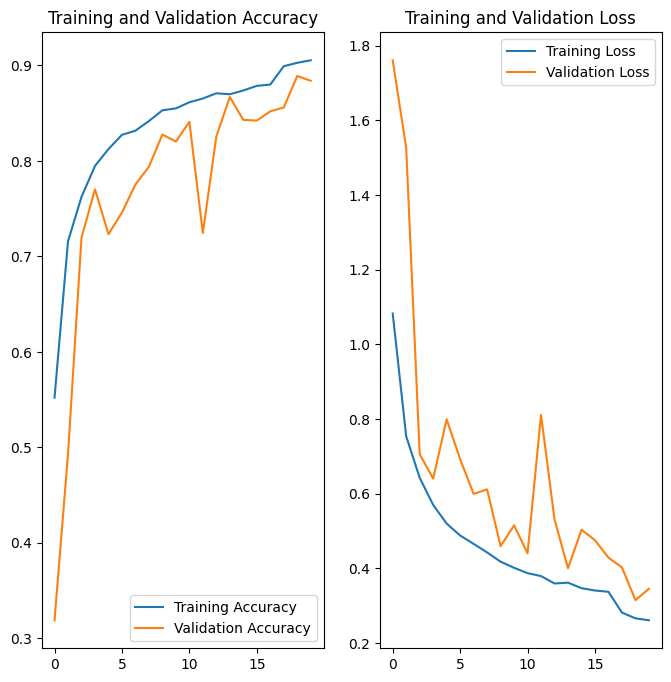

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
